In [97]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [98]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [99]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

# -- Create directories
checkDir(out_path)

### Open SST data
Open nino3.4_trend data (NOT detrended)

In [102]:
##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*_trend.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*_trend.nc' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

## Normalization
# for i,item in enumerate(nino34_hist):
#     nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

# for i,item in enumerate(nino34_ssp):
#     nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
nino34_hist = [a.resample(time="QS", label='left').mean() for a in nino34_hist]
nino34_ssp = [a.resample(time="QS", label='left').mean() for a in nino34_ssp]

# Convert to dataarray
nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

# Delete useless empty dimension
nino34_hist = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_hist]
nino34_ssp = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_ssp]


### Open LAND data

In [103]:
data_path = 'E:/Data/analysis/'

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_nep.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_hist_nep = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_nep]

# Uniform calendar
for i, item in enumerate(ds_hist_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_nep = [a.resample(time="QS", label='left').mean() for a in ds_hist_nep]
ds_ssp_nep = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -3.7270379e-07)
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)

        # Correct for inverse NEP value in CESM2

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_nep[i] = ds_hist_nep[i]*-1
                ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        else:
                None

In [104]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_pr.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_pr.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_pr = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_pr]
ds_ssp_pr = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_pr]

# Correct pr ssp585 UKESM-r4 from lon:192 to lon:191
ds_ssp_pr[41] = ds_ssp_pr[41].isel(lon = slice(0,191))
# Correct pr hist UKESM-r4 from lon:192 to lon:191
ds_hist_pr[42] = ds_hist_pr[42].isel(lon = slice(0,191))

# Resample from months to seasons
ds_hist_pr = [a.resample(time="QS", label='left').mean() for a in ds_hist_pr]
ds_ssp_pr = [a.resample(time="QS", label='left').mean() for a in ds_ssp_pr]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_pr[i] = ds_hist_pr[i].where(ds_hist_pr[i] != -3.7270379e-07)
        ds_ssp_pr[i] = ds_ssp_pr[i].where(ds_ssp_pr[i] != -6.18386321e-06)

In [105]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_tas.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_tas.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_tas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_tas]
ds_ssp_tas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_tas]

# Resample from months to seasons
ds_hist_tas = [a.resample(time="QS", label='left').mean() for a in ds_hist_tas]
ds_ssp_tas = [a.resample(time="QS", label='left').mean() for a in ds_ssp_tas]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_tas[i] = ds_hist_tas[i].where(ds_hist_tas[i] != -3.7270379e-07)
        ds_ssp_tas[i] = ds_ssp_tas[i].where(ds_ssp_tas[i] != -6.18386321e-06)

In [106]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_mrso.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_mrso.append(content)    

# Subsetting latitude
ds_hist_mrso = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_mrso]
ds_ssp_mrso = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_mrso]

# Uniform calendar
for i, item in enumerate(ds_hist_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_mrso = [a.resample(time="QS", label='left').mean() for a in ds_hist_mrso]
ds_ssp_mrso = [a.resample(time="QS", label='left').mean() for a in ds_ssp_mrso]


In [107]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_rsds.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_rsds.append(content)    

# Subsetting latitude
ds_hist_rsds = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_rsds]
ds_ssp_rsds = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_rsds]

# Uniform calendar
for i, item in enumerate(ds_hist_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_rsds = [a.resample(time="QS", label='left').mean() for a in ds_hist_rsds]
ds_ssp_rsds = [a.resample(time="QS", label='left').mean() for a in ds_ssp_rsds]


In [108]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'hfls'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_hfls.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_hfls.append(content)    

# Subsetting latitude
ds_hist_hfls = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_hfls]
ds_ssp_hfls = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_hfls]

# Uniform calendar
for i, item in enumerate(ds_hist_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

# Detrending of 1st order
ds_hist_hfls = [detrend_dim(a, "time", 1) for a in ds_hist_hfls]
ds_ssp_hfls = [detrend_dim(a, "time", 1) for a in ds_ssp_hfls]

# Resample from months to seasons
ds_hist_hfls = [a.resample(time="QS", label='left').mean() for a in ds_hist_hfls]
ds_ssp_hfls = [a.resample(time="QS", label='left').mean() for a in ds_ssp_hfls]


### Open CO2

In [109]:

data = np.genfromtxt('G:/Shared drives/Amazon_ENSO_work/analysis/co2_ssp585.txt', delimiter=' ')

# Extract lon, lat, and data values from the loaded data
time = data[:, 0]
values = data[:, 2]

ds_co2 = []
for i,item in enumerate(ds_hist_nep):

    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    co2 = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'], 
                            name='ppm').astype("float64")

    for i,item in enumerate(time):
        co2[i] = values[i]
    ds_co2.append(co2)

ds_co2 = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_co2]

### Correct for lon lat mishape and values

In [110]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_pr)]
ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_pr)]
ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_pr)]
ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_pr)]
ds_hist_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_hfls, ds_hist_pr)]
ds_ssp_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_hfls, ds_ssp_pr)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
ds_hist_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_hfls,ds_hist_nep)]
ds_ssp_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_hfls,ds_ssp_nep)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep)]

ds_co2 = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_co2,ds_ssp_nep)]


### Merge the time series

In [111]:
ds_nep =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_nep, ds_ssp_nep)]
ds_mrso =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_mrso, ds_ssp_mrso)]
ds_tas =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_tas, ds_ssp_tas)]
ds_rsds =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_rsds, ds_ssp_rsds)]
ds_hfls =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_hfls, ds_ssp_hfls)]
ds_pr =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_pr, ds_ssp_pr)]
ds_enso = [xr.concat([a,b], dim = "time") for a,b in zip(nino34_hist, nino34_ssp)]

In [181]:
# Spurious dimension

for i,item in enumerate(ds_enso):
    if len(ds_enso[i].dims) < 2:
        None
    else:
        ds_enso[i] = item.sel(tos = 1)

In [249]:
ds_co2 = [a.assign_coords(time = b.time.values) for a,b in zip(ds_co2,ds_nep)]

ValueError: conflicting sizes for dimension 'time': length 251 on <this-array> and length 1004 on {'time': 'time', 'lat': 'lat', 'lon': 'lon'}

### Ridge Reg with ENSO signal

ENSO is linearly removed from original variables signal, The residuals are then used in the ridge regression 

In [183]:
# Estimate the residuals of regression with nino34 to isolate its effect on pr and tas
seas = "DJF"

# Reshape variables
X1 = [a.sel(time = a.time.dt.season==seas) for a in ds_enso]
Y = [a.sel(time = a.time.dt.season==seas) for a in ds_pr]
Y1 = [a.sel(time = a.time.dt.season==seas) for a in ds_tas]
Y2 = [a.sel(time = a.time.dt.season==seas) for a in ds_mrso]
Y3 = [a.sel(time = a.time.dt.season==seas) for a in ds_rsds]
Y4 = [a.sel(time = a.time.dt.season==seas) for a in ds_hfls]

res_pr = []
res_tas = []
res_mrso = []
res_rsds = []
res_hfls = []
for i, item in enumerate(ds_nep):

    content = lag_linregress_3D(X1[i],Y[i])
    content1 = lag_linregress_3D(X1[i],Y1[i])
    content2 = lag_linregress_3D(X1[i],Y2[i])
    content3 = lag_linregress_3D(X1[i],Y3[i])
    content4 = lag_linregress_3D(X1[i],Y4[i])

    res_pr.append(content)
    res_tas.append(content1)
    res_mrso.append(content2)
    res_rsds.append(content3)
    res_hfls.append(content4)


### Calculation

To avoid Singular Matrix error while performing regression it's necessary to fill NaN NOT with zero but with a not-zero number (eg 0.001) 

By standardizing Soil Moisturre SSP with historical Soil Moisture we get infinite values for some realization. Thus substitute inf with 0.001

In [ ]:
from sklearn import linear_model
from regressors import stats   

# Define regression technique
# Ridge Regression with Cross-Validation
# alphas = np.linspace(.000001, 1)
# alphas = np.logspace(-6, 2, 10)
# ridge = linear_model.RidgeCV(alphas = alphas, cv =5)

# Ridge Regression without Cross-Validation
ridge = linear_model.Ridge()

# orical
coef_ridge = []
r2_ridge = []
pred_ridge = []
pval_ridge = []
for i, item in enumerate(ds_nep):
    pass
    #1. Reshape variables
    enso = ds_enso[i].rename("sst").sel(time = nino34[i].time.dt.season==seas).sel(time = slice("1901-01", "1960-12"))
    X1 = res_pr[i].rename("pr")
    X2 = res_tas[i].rename("tas")
    X3 = res_mrso[i].rename("mrso").fillna(0.001)
    X4 = res_rsds[i].rename("rsds")
    X5 = res_hfls[i].rename("hfls")

    Y = ds_nep[i].fillna(0.001).sel(time = ds_nep[i].time.dt.season==seas)

    #3. Stack on 1D vector
    enso = enso.stack(cell = ["time"])
    X1 = X1.stack(cell = ["lon","lat"])
    X2 = X2.stack(cell = ["lon","lat"])
    X3 = X3.stack(cell = ["lon","lat"])
    X4 = X4.stack(cell = ["lon","lat"])
    X5 = X5.stack(cell = ["lon","lat"])

    Y = Y.stack(cell = ["lon","lat"])

    #4. Create Dataarray with ENSO signal in every grid cell to perform regression
    Xenso = xr.DataArray(data=None, coords=[X1.time, X1.cell], dims=["time","cell"])
    for c in Xenso.cell:
        locator = {'cell':c}
        Xenso.loc[locator] = enso.values
        Xenso.values = Xenso.values.astype("float64")       # To avoid the resulting values are "object" rather than "float64" 
    Xenso = Xenso.rename("sst")

    #5. Create empty dataarray to store regression coefficients
    coef = xr.DataArray(data=None, coords=[X1.time,X1.cell], dims=["time","cell"])
    coef["pr"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    coef["tas"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    coef["mrso"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    coef["sst"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    coef["rsds"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    coef["hfls"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])

    # Create empty dataarray to store p-values
    pval = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["pr"] = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["tas"] = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["mrso"] = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["sst"] = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["rsds"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pval["hfls"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])

    # Create empty datarray to store R2 and Y predicted 
    r_squared = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
    pred = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
    pred["nep"] = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time", "cell"])

    #6. Iterate over cells (lan*lon)
    for c in X1.cell:
        locator = {'cell':c}

        # merge predictors in one numpy array
        df = np.array((X1.loc[locator].values, X2.loc[locator].values, X3.loc[locator].values, X4.loc[locator].values, X5.loc[locator].values, Xenso.loc[locator].values)); df = df.T
        
        model = ridge.fit(df,Y.loc[locator].values)
        r2 = ridge.score(df,Y.loc[locator])
        ypred = ridge.predict(df)

        coef["pr"].loc[locator] = model.coef_[0]
        coef["tas"].loc[locator] = model.coef_[1]
        coef["mrso"].loc[locator] = model.coef_[2]
        coef["rsds"].loc[locator] = model.coef_[3]
        coef["hfls"].loc[locator] = model.coef_[4]
        coef["sst"].loc[locator] = model.coef_[5]

        # # p-value of the index "0" refers to the intercept
        pval["pr"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[1]
        pval["tas"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[2]
        pval["mrso"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
        pval["rsds"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[4]
        pval["hfls"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[5]
        pval["sst"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[6]
        
        r_squared.loc[locator] = r2
        pred["nep"].loc[locator] = ypred

    #7. Unstack array
    coef = coef.unstack()
    coef = xr.concat([coef.pr, coef.tas, coef.mrso, coef.rsds, coef.hfls, coef.sst], dim = "coefficients")     #ORDER of the coefficients
    coef["pr"] = coef.pr.astype(np.float64)
    coef["tas"] = coef.tas.astype(np.float64)
    coef["mrso"] = coef.mrso.astype(np.float64)
    coef["rsds"] = coef.rsds.astype(np.float64)
    coef["hfls"] = coef.hfls.astype(np.float64)
    coef["sst"] = coef.sst.astype(np.float64)

    pval = pval.unstack()
    pval = xr.concat([pval.pr, pval.tas, pval.mrso, pval.rsds, pval.hfls, pval.sst], dim = "p-values")
    pval["pr"] = pval.pr.astype(np.float64)
    pval["tas"] = pval.tas.astype(np.float64)
    pval["mrso"] = pval.mrso.astype(np.float64)
    pval["rsds"] = pval.rsds.astype(np.float64)
    pval["hfls"] = pval.hfls.astype(np.float64)
    pval["sst"] = pval.sst.astype(np.float64)
    
    r_squared = r_squared.astype(np.float64).unstack()
    pred = pred.astype(np.float64).unstack()

    coef_ridge.append(coef)
    r2_ridge.append(r_squared)
    pred_ridge.append(pred)
    pval_ridge.append(pval)
    print(i)
    

# Save and export regression list data
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_enso_1901-1960_DJF_coef_e"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_coef_e"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_1901-1960_DJF_pval_e"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_pval_e"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_1901-1960_DJF_r2_e"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_r2_e"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_1901-1960_DJF_ypred_e"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_ypred_e"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_ssp, fp)



In [184]:
from sklearn import linear_model
from regressors import stats   
ridge = linear_model.Ridge()

def new_ridgereg(x1, x2, x3, x4, x5, x6, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    x1 = x1.reshape(-1,1); x2 = x2.reshape(-1,1); x3 = x3.reshape(-1,1); x4 = x4.reshape(-1,1); x5 = x5.reshape(-1,1); x6 = x6.reshape(-1,1)#; x7 = x7.reshape(-1,1)
    y = y.reshape(-1,1)
    X = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    model = ridge.fit(X, y)
    r2 = ridge.score(X, y)
    # ypred = ridge.predict(X)
    coef = model.coef_
    pval = stats.coef_pval(model,X,y)[1:]         # First p-value [0] is for intercept
    return coef,pval,np.array([r2])


coef_ridge = []
r2_ridge = []
pval_ridge = []
enso = []

for i, item in enumerate(ds_nep):

    # Generate enso xarray
    time = ds_enso[i].time.values
    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    enso = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'], 
                            name='sst').astype("float64")

    for t,item in enumerate(time):
        enso[t] = ds_enso[i][t].values

    # Select the predictors
    X1 = res_pr[i].fillna(0.001).rename("pr").sel(time = res_pr[i].time.dt.season==seas)
    X2 = res_tas[i].fillna(0.001).rename("tas").sel(time = res_tas[i].time.dt.season==seas)
    # X3 = res_mrso[i].fillna(0.001).rename("mrso").sel(time = res_mrso[i].time.dt.season==seas).fillna(1e-5)
    X4 = res_rsds[i].fillna(0.001).rename("rsds").sel(time = res_rsds[i].time.dt.season==seas)
    X5 = res_hfls[i].fillna(0.001).rename("hfls").sel(time = res_hfls[i].time.dt.season==seas)
    X6 = ds_co2[i].fillna(0.001).rename("co2")
    X7 = enso.rename("sst").sel(time = enso.time.dt.season==seas)
    Y = ds_nep[i].fillna(0.001).sel(time = ds_nep[i].time.dt.season==seas)
    X6["time"] = Y.time.values      # correct co2 YYYY in YYYY-MM-DD

    # return new DataArrays
    coef, pval, r2 = xr.apply_ufunc(new_ridgereg,
                                            X1, X2, X4, X5, X6, X7, Y,
                                            input_core_dims=[['time'],['time'], ['time'], ['time'],['time'], ['time'], ['time']],
                                            output_core_dims=[['coef'], ['pval'], ['r2']],
                                            vectorize=True,
                                            dask="parallelized",
                                            output_dtypes=['float64', 'float64', 'float64'],
                                            output_sizes={"coef":7, "pval":7, "r2":7},
                                        )

    coef_ridge.append(coef)
    r2_ridge.append(r2)
    pval_ridge.append(pval)
    
    print(i)

# Save and export regression list data
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_co2_DJF_coef_c1"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge, fp)

with open(os.path.join(data_path+"ridge_reg_co2_DJF_pval_c1"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge, fp)

with open(os.path.join(data_path+"ridge_reg_co2_DJF_r2_c1"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge, fp)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


### Import saved data

*_c is the same of MLR_computation but with added co2\
*_c1 has ALL variables not detrended (also nino34)

In [185]:
# Open regression list data

import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_co2_DJF_coef_c1"), "rb") as fp:   #Pickling
    coef_ridge = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_co2_DJF_pval_c1"), "rb") as fp:   #Pickling
    pval_ridge = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_co2_DJF_r2_c1"), "rb") as fp:   #Pickling
    r2_ridge = pickle.load(fp)



In [186]:
# Because I forgot to concatenate the results of the MLR calculation 

coef_ridge = [xr.concat([a.sel(coef = 0), a.sel(coef = 1), a.sel(coef = 2), a.sel(coef = 3), a.sel(coef = 4), a.sel(coef = 5)], dim = "coefficients") for a in coef_ridge]

pval_ridge = [xr.concat([a.sel(pval = 0), a.sel(pval = 1), a.sel(pval = 2), a.sel(pval = 3), a.sel(pval = 4), a.sel(pval = 5)], dim = "pvalues") for a in pval_ridge]


In [187]:
# Define esm

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

# Mean response of ESM
coef_ridge = xr_mean_list(coef_ridge, esm)

pval_ridge = xr_mean_list(pval_ridge, esm)

r2_ridge = xr_mean_list(r2_ridge, esm)


In [188]:
pval_ridge_fdr = []
for i, item in enumerate(pval_ridge):
    reject, xpvals_corrected = xr_multipletest(pval_ridge[i])
    pval_ridge_fdr.append(xpvals_corrected)

### Model Diversity and Predictor Diversity

In [189]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [190]:
# Zonal Mean in Amazon basin 
coef_ridge_amz = [zonal_stat(a, geodf).sel(region = 1) for a in coef_ridge]

pval_ridge_amz = [zonal_stat(a, geodf).sel(region = 1) for a in pval_ridge]

r2_ridge_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge]

In [191]:
# Rename predictors 
coef_ridge_pr_amz = [a.sel(coefficients = 0).rename("pr") for a in coef_ridge_amz]
coef_ridge_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_amz]
coef_ridge_rsds_amz = [a.sel(coefficients = 2).rename("rsds") for a in coef_ridge_amz]
coef_ridge_hfls_amz = [a.sel(coefficients = 3).rename("hfls") for a in coef_ridge_amz]
coef_ridge_co2_amz = [a.sel(coefficients = 4).rename("co2") for a in coef_ridge_amz]
coef_ridge_enso_amz = [a.sel(coefficients = 4).rename("enso") for a in coef_ridge_amz]


In [192]:
# Convert to pandas dataframe

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

# set of esm names
esm = list(set(esm))
esm.sort()

import pandas as pd

df_coef_ridge_pr = xr.concat(coef_ridge_pr_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_pr = df_coef_ridge_pr.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_pr.index, esm)))
df_coef_ridge_tas = xr.concat(coef_ridge_tas_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_tas = df_coef_ridge_tas.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_tas.index, esm)))
df_coef_ridge_enso = xr.concat(coef_ridge_enso_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_enso = df_coef_ridge_enso.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_enso.index, esm)))
df_coef_ridge_rsds = xr.concat(coef_ridge_rsds_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_rsds = df_coef_ridge_rsds.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_rsds.index, esm)))
df_coef_ridge_hfls = xr.concat(coef_ridge_hfls_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_hfls = df_coef_ridge_hfls.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_hfls.index, esm)))
df_coef_ridge_co2 = xr.concat(coef_ridge_co2_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_co2 = df_coef_ridge_co2.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_co2.index, esm)))

df_amz = pd.concat([df_coef_ridge_pr, df_coef_ridge_tas, df_coef_ridge_rsds, df_coef_ridge_hfls, df_coef_ridge_co2, df_coef_ridge_enso], axis = 1)


<AxesSubplot: xlabel='esm'>

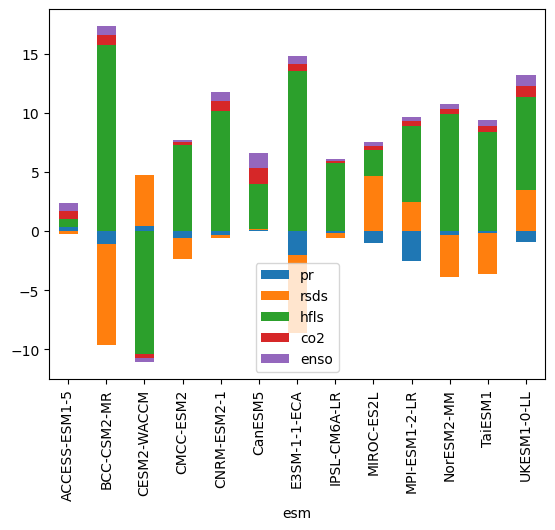

In [199]:
df_amz.drop(columns = "tas").plot.bar(stacked = True)

,pr,rsds,hfls,co2,enso
esm,,,,,
ACCESS-ESM1-5,0.329050,-0.238301,0.657539,0.691718,0.691718
BCC-CSM2-MR,-1.112417,-8.484458,15.780278,0.791243,0.791243
CESM2-WACCM,0.438283,4.351395,-10.379594,-0.344189,-0.344189
CMCC-ESM2,-0.575620,-1.774826,7.315063,0.212576,0.212576
CNRM-ESM2-1,-0.303565,-0.314164,10.192214,0.803983,0.803983
CanESM5,0.109219,0.032389,3.867297,1.290609,1.290609
E3SM-1-1-ECA,-2.043323,-6.588783,13.528041,0.650814,0.650814
IPSL-CM6A-LR,-0.128830,-0.443035,5.725560,0.184855,0.184855
MIROC-ES2L,-0.992285,4.645008,2.225085,0.325411,0.325411


t-test for regression coefficients

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation

df = pd.DataFrame([[label, val, 'historical'] for label, values in df_amz_hist.drop(columns = "nep").items() for val in values]
                  + [[label, val, 'ssp585'] for label, values in df_amz.drop(columns = "nep").items() for val in values],
                  columns=['variables', 'coefficient', 'scenario'])

order = ["enso", "pr", "rsds", "tas", "hfls"]

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, x='variables', y='coefficient', hue='scenario', palette=['cornflowerblue', 'indianred'], order = order, ax=ax)
ax.set(xlabel='variables', ylabel='gCm$^{-2}$sd$^{-1}$')  
add_stat_annotation(ax, data=df, x='variables', y='coefficient', hue='scenario', order=order,
                    box_pairs=[(("enso", "historical"), ("enso", "ssp585")), (("pr", "historical"), ("pr", "ssp585")), (("rsds", "historical"), ("rsds", "ssp585")), 
                               (("tas", "historical"), ("tas", "ssp585")), (("hfls", "historical"), ("hfls", "ssp585"))],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

title = "predictors importance"
output_file = os.path.join(out_path, title) + "_c_violin.png"
plt.savefig(output_file, bbox_inches='tight')


### Plot coefficients and R2

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

seas = "DJF"

# --- Define data to plot
to_plot = "coef_ssp"; predictor = "rsds"

if to_plot == "coef_hist":
    data_plot = coef_ridge_hist.copy()
    hatch_plot = pval_ridge_hist_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3NEP_rsds historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "coef_ssp":
    data_plot = coef_ridge_ssp.copy()
    hatch_plot = pval_ridge_ssp_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3NEP_rsds ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "delta":
    data_plot = delta_coef_ridge.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "BrBG"
    title = '\u0394\u03B3NEP_enso ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if predictor == "pr":
        data_plot[i] = data_plot[i].sel(coefficients = 0); hatch_plot[i] = hatch_plot[i].sel(pvalues = 0)
    if predictor == "tas":
        data_plot[i] = data_plot[i].sel(coefficients = 1); hatch_plot[i] = hatch_plot[i].sel(pvalues = 1)
    if predictor == "sst":
        data_plot[i] = data_plot[i].sel(coefficients = 2); hatch_plot[i] = hatch_plot[i].sel(pvalues = 2)
    if predictor == "rsds":
        data_plot[i] = data_plot[i].sel(coefficients = 3); hatch_plot[i] = hatch_plot[i].sel(pvalues = 3)
    if predictor == "hfls":
        data_plot[i] = data_plot[i].sel(coefficients = 4); hatch_plot[i] = hatch_plot[i].sel(pvalues = 4)

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    lons = hatch_plot[i].lon
    lats = hatch_plot[i].lat
    # pearson_r_single_95x =[]
    # pearson_r_single_95y =[] 
    # for y,itemy in enumerate(lats):
    #     for x,itemx in enumerate(lons):
    #         if hatch_plot[i][x][y]<0.05:                   # Define the significance level of Mann Whitney test                       
    #             contentx =itemx                                          # If < sign significant gridcells, if > sign not-significant gridcells
    #             contenty =itemy
    #             pearson_r_single_95x.append(contentx)
    #             pearson_r_single_95y.append(contenty)

    # map1 = ax.pcolormesh(lons, lats, data_plot[i].sel(coefficients = 0), vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=-200, vmax=200, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    sign = np.ma.masked_greater(hatch_plot[i], 0.05)

    map = ax.pcolor(lats, lons, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha = 0)
    # ax.plot(pearson_r_single_95x, pearson_r_single_95y, "o", transform = ccrs.PlateCarree(), markersize = 0.6, color="black")

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- Define data to plot
to_plot = "r2_ssp"

if to_plot == "r2_hist":
    data_plot = r2_ridge_hist.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "r2_ssp":
    data_plot = r2_ridge_ssp.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "pred_hist":
    data_plot = pred_ridge_hist
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_NEP ssp585 - Ridge Regression - ENSO -'  + seas

if to_plot == "pred_ssp":
    data_plot = pred_ridge_ssp
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_NEP ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    # lons = data_plot[i].lon
    # lats = data_plot[i].lat
    # map1 = ax.pcolormesh(lons, lats, data_plot[i], vmin=0, vmax=1, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].astype(np.float64).plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=0, vmax=1, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### MultiModel mean and St Dev

In [ ]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

Regrid to 1x1

In [ ]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

coef_ridge_hist = [lon180(a) for a in coef_ridge_hist]
coef_ridge_ssp = [lon180(a) for a in coef_ridge_ssp]

ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 30, 1)

regrid = [xe.Regridder(a, ds_out, "bilinear") for a in coef_ridge_hist]

coef_ridge_hist = [reg(a, keep_attrs=True) for reg,a in zip(regrid,coef_ridge_hist)]
coef_ridge_ssp = [reg(a, keep_attrs=True) for reg,a in zip(regrid,coef_ridge_ssp)]

In [ ]:
# Separate predictors HIST
coef_ridge_hist_pr = xr.concat([a.sel(coefficients = 0) for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_tas = xr.concat([a.sel(coefficients = 1).rename("tas") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_enso = xr.concat([a.sel(coefficients = 2).rename("enso") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_rsds = xr.concat([a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_hfls = xr.concat([a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_hist],dim = "esm")

# Separate predictors SSP
coef_ridge_ssp_pr = xr.concat([a.sel(coefficients = 0) for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_tas = xr.concat([a.sel(coefficients = 1).rename("tas") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_enso = xr.concat([a.sel(coefficients = 2).rename("enso") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_rsds = xr.concat([a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_hfls = xr.concat([a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_ssp],dim = "esm")


In [ ]:
# Multimodel Mean and Std

coef_ridge_hist_pr_mean = coef_ridge_hist_pr.mean(dim = "esm")
coef_ridge_hist_tas_mean = coef_ridge_hist_tas.mean(dim = "esm")
coef_ridge_hist_enso_mean = coef_ridge_hist_enso.mean(dim = "esm")
coef_ridge_hist_rsds_mean = coef_ridge_hist_rsds.mean(dim = "esm")
coef_ridge_hist_hfls_mean = coef_ridge_hist_hfls.mean(dim = "esm")

coef_ridge_ssp_pr_mean = coef_ridge_ssp_pr.mean(dim = "esm")
coef_ridge_ssp_tas_mean = coef_ridge_ssp_tas.mean(dim = "esm")
coef_ridge_ssp_enso_mean = coef_ridge_ssp_enso.mean(dim = "esm")
coef_ridge_ssp_rsds_mean = coef_ridge_ssp_rsds.mean(dim = "esm")
coef_ridge_ssp_hfls_mean = coef_ridge_ssp_hfls.mean(dim = "esm")

coef_ridge_hist_pr_std = coef_ridge_hist_pr.std(dim = "esm")
coef_ridge_hist_tas_std = coef_ridge_hist_tas.std(dim = "esm")
coef_ridge_hist_enso_std = coef_ridge_hist_enso.std(dim = "esm")
coef_ridge_hist_rsds_std = coef_ridge_hist_rsds.std(dim = "esm")
coef_ridge_hist_hfls_std = coef_ridge_hist_hfls.std(dim = "esm")

coef_ridge_ssp_pr_std = coef_ridge_ssp_pr.std(dim = "esm")
coef_ridge_ssp_tas_std = coef_ridge_ssp_tas.std(dim = "esm")
coef_ridge_ssp_enso_std = coef_ridge_ssp_enso.std(dim = "esm")
coef_ridge_ssp_rsds_std = coef_ridge_ssp_rsds.std(dim = "esm")
coef_ridge_ssp_hfls_std = coef_ridge_ssp_hfls.std(dim = "esm")


Plot MM predictors mean and Std

In [ ]:
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

predictor = "rsds"; scenario = "historical"

if scenario == "historical":
    if predictor == "pr":
        mean_plot = coef_ridge_hist_pr_mean; std_plot = coef_ridge_hist_pr_std; title = "MM Precipitation Ridge Regression - " + scenario 
    if predictor == "tas":
        mean_plot = coef_ridge_hist_tas_mean; std_plot = coef_ridge_hist_tas_std; title = "MM Temperature Ridge Regression - " + scenario
    if predictor == "enso":
        mean_plot = coef_ridge_hist_enso_mean; std_plot = coef_ridge_hist_enso_std; title = "MM enso Ridge Regression - " + scenario
    if predictor == "rsds":
        mean_plot = coef_ridge_hist_rsds_mean; std_plot = coef_ridge_hist_rsds_std; title = "MM Surface Shortwave Radiation Ridge Regression - " + scenario
    if predictor == "hfls":
        mean_plot = coef_ridge_hist_hfls_mean; std_plot = coef_ridge_hist_hfls_std; title = "MM Latent Heat Ridge Regression - " + scenario
else:
    if predictor == "pr":
        mean_plot = coef_ridge_ssp_pr_mean; std_plot = coef_ridge_ssp_pr_std; title = "MM Precipitation Ridge Regression - " + scenario
    if predictor == "tas":
        mean_plot = coef_ridge_ssp_tas_mean; std_plot = coef_ridge_ssp_tas_std; title = "MM Temperature Ridge Regression - " + scenario
    if predictor == "enso":
        mean_plot = coef_ridge_ssp_enso_mean; std_plot = coef_ridge_ssp_enso_std; title = "MM enso Ridge Regression - " + scenario
    if predictor == "rsds":
        mean_plot = coef_ridge_ssp_rsds_mean; std_plot = coef_ridge_ssp_rsds_std; title = "MM Surface Shortwave Radiation Ridge Regression - " + scenario
    if predictor == "hfls":
        mean_plot = coef_ridge_ssp_hfls_mean; std_plot = coef_ridge_ssp_hfls_std; title = "MM Latent Heat Ridge Regression - " + scenario

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(121, projection = ccrs.PlateCarree())

map = mean_plot.plot.pcolormesh(ax = ax1, x = "lon", y = "lat", cmap="RdBu", vmin=-50, vmax=50, 
                                                transform = ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
ax1.add_feature(amz)
ax1.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
ax1.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_xlabel(""); ax1.set_ylabel("")
# Latitude labels
ax1.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax1.yaxis.set_major_formatter(lat_formatter)

ax2 = fig.add_subplot(122, projection = ccrs.PlateCarree())

map1 = std_plot.plot.pcolormesh(ax = ax2, x = "lon", y = "lat", cmap="RdYlGn_r", vmin=0, vmax=80, 
                                                transform = ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
ax2.add_feature(amz)
ax2.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
ax2.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.set_xlabel(""); ax2.set_ylabel("")
# Latitude labels
ax2.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax2.yaxis.set_major_formatter(lat_formatter)

ax1.set_title("Mean")
ax2.set_title("DevStd")

fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.25, 0.01, 0.5]) # Left, Bottom, Width, Height
cbar1_ax = fig.add_axes([1.08, 0.25, 0.01, 0.5]) # Left, Bottom, Width, Height

clb = fig.colorbar(map, cax=cbar_ax)
clb1 = fig.colorbar(map1, cax=cbar1_ax)

clb1.set_label("gCm$^{-2}$ (sd)$^{-1}$",fontsize= 10,labelpad = 0.2)
fig.suptitle(title, y = 0.85, fontsize = 14)

output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Plot MM agreement

In [ ]:
# Put 1 when value is positive and 0 when negative
# Take the absolute value of the sum, if 9 out of 13 esm agree (9/13 = 0.69), then hatch

mm_sign_pr = xr.where(coef_ridge_hist_pr>0, 1, -1)
mm_sign_tas = xr.where(coef_ridge_hist_tas>0, 1, -1)
mm_sign_enso = xr.where(coef_ridge_hist_enso>0, 1, -1)
mm_sign_rsds = xr.where(coef_ridge_hist_rsds>0, 1, -1)
mm_sign_hfls = xr.where(coef_ridge_hist_hfls>0, 1, -1)

mm_sign_pr_hist = np.ma.masked_greater((np.abs(mm_sign_pr.sum(dim = "esm")/13)), 0.69)
mm_sign_tas_hist = np.ma.masked_greater((np.abs(mm_sign_tas.sum(dim = "esm")/13)), 0.69)
mm_sign_enso_hist = np.ma.masked_greater((np.abs(mm_sign_enso.sum(dim = "esm")/13)), 0.69)
mm_sign_rsds_hist = np.ma.masked_greater((np.abs(mm_sign_rsds.sum(dim = "esm")/13)), 0.69)
mm_sign_hfls_hist = np.ma.masked_greater((np.abs(mm_sign_hfls.sum(dim = "esm")/13)), 0.69)

mm_sign_pr = xr.where(coef_ridge_ssp_pr>0, 1, -1)
mm_sign_tas = xr.where(coef_ridge_ssp_tas>0, 1, -1)
mm_sign_enso = xr.where(coef_ridge_ssp_enso>0, 1, -1)
mm_sign_rsds = xr.where(coef_ridge_ssp_rsds>0, 1, -1)
mm_sign_hfls = xr.where(coef_ridge_ssp_hfls>0, 1, -1)

mm_sign_pr_ssp = np.ma.masked_greater((np.abs(mm_sign_pr.sum(dim = "esm")/13)), 0.69)
mm_sign_tas_ssp = np.ma.masked_greater((np.abs(mm_sign_tas.sum(dim = "esm")/13)), 0.69)
mm_sign_enso_ssp = np.ma.masked_greater((np.abs(mm_sign_enso.sum(dim = "esm")/13)), 0.69)
mm_sign_rsds_ssp = np.ma.masked_greater((np.abs(mm_sign_rsds.sum(dim = "esm")/13)), 0.69)
mm_sign_hfls_ssp = np.ma.masked_greater((np.abs(mm_sign_hfls.sum(dim = "esm")/13)), 0.69)

In [ ]:
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

scenario = "delta"

if scenario == "historical":
    mean_plot = [coef_ridge_hist_pr_mean,coef_ridge_hist_tas_mean,coef_ridge_hist_enso_mean,coef_ridge_hist_rsds_mean,coef_ridge_hist_hfls_mean]
    hatch_plot = [mm_sign_pr_hist, mm_sign_tas_hist,mm_sign_enso_hist,mm_sign_rsds_hist,mm_sign_hfls_hist]

if scenario == "ssp585":
    mean_plot = [coef_ridge_ssp_pr_mean,coef_ridge_ssp_tas_mean,coef_ridge_ssp_enso_mean,coef_ridge_ssp_rsds_mean,coef_ridge_ssp_hfls_mean]
    hatch_plot = [mm_sign_pr_ssp, mm_sign_tas_ssp,mm_sign_enso_ssp,mm_sign_rsds_ssp,mm_sign_hfls_ssp]

if scenario == "delta":
    mean_plot = [coef_ridge_ssp_pr_mean - coef_ridge_hist_pr_mean,
                    coef_ridge_ssp_tas_mean - coef_ridge_hist_tas_mean,
                    coef_ridge_ssp_enso_mean - coef_ridge_hist_enso_mean,
                    coef_ridge_ssp_rsds_mean -coef_ridge_hist_rsds_mean,
                    coef_ridge_ssp_hfls_mean - coef_ridge_hist_hfls_mean]
    # hatch_plot = [mm_sign_pr_ssp, mm_sign_tas_ssp,mm_sign_enso_ssp,mm_sign_rsds_ssp,mm_sign_hfls_ssp]

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

# Create the figure 
fig = plt.figure(figsize=(11, 6)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 8)

for i, ax in enumerate(mean_plot):

    if i < 3:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if i > 2:
        ax = fig.add_subplot(gs[1, 2 * i - 5 : 2 * i - 3], projection = ccrs.PlateCarree())

    lats = mean_plot[i].lat; lons = mean_plot[i].lon
    map1 = mean_plot[i].plot.pcolormesh(vmin=-40, vmax=40, cmap="RdBu", transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    # map = ax.pcolor(lons, lats, hatch_plot[i], hatch = '///', transform = ccrs.PlateCarree(), alpha = 0)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
    # Longitude labels
    ax.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    # Latitude labels
    ax.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(mean_plot[i].name)

fig.subplots_adjust(bottom=0.0, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.0)
fig.tight_layout()
cbar_ax = fig.add_axes([0.78, 0.25, 0.02, 0.5]) # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax)
clb.set_label("gCm$^{-2}$ (sd)$^{-1}$",fontsize= 10,labelpad = 0.2)
title = "MM Ridge Regression coefficients agreement - " + scenario
fig.suptitle(title, y = 1, fontsize = 14)

# Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Plot t-test Delta coefficient

In [ ]:
coef_pr_hist = mask_shape(coef_ridge_hist_pr_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_tas_hist = mask_shape(coef_ridge_hist_tas_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_enso_hist = mask_shape(coef_ridge_hist_enso_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_rsds_hist = mask_shape(coef_ridge_hist_rsds_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_hfls_hist = mask_shape(coef_ridge_hist_hfls_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")

coef_pr_ssp = mask_shape(coef_ridge_ssp_pr_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_tas_ssp = mask_shape(coef_ridge_ssp_tas_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_enso_ssp = mask_shape(coef_ridge_ssp_enso_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_rsds_ssp = mask_shape(coef_ridge_ssp_rsds_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_hfls_ssp = mask_shape(coef_ridge_ssp_hfls_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")

In [ ]:
# Convert to pandas dataframe
import pandas as pd

df_coef_pr_hist = coef_pr_hist.to_dataframe()[["pr"]]; df_coef_tas_hist = coef_tas_hist.to_dataframe()[["tas"]]
df_coef_enso_hist = coef_enso_hist.to_dataframe()[["enso"]]; df_coef_rsds_hist = coef_rsds_hist.to_dataframe()[["rsds"]]
df_coef_hfls_hist = coef_hfls_hist.to_dataframe()[["hfls"]]

df_hist = pd.concat([df_coef_pr_hist, df_coef_tas_hist, df_coef_enso_hist, df_coef_rsds_hist, df_coef_hfls_hist], axis = 1)

df_coef_pr_ssp = coef_pr_ssp.to_dataframe()[["pr"]]; df_coef_tas_ssp = coef_tas_ssp.to_dataframe()[["tas"]]
df_coef_enso_ssp = coef_enso_ssp.to_dataframe()[["enso"]]; df_coef_rsds_ssp = coef_rsds_ssp.to_dataframe()[["rsds"]]
df_coef_hfls_ssp = coef_hfls_ssp.to_dataframe()[["hfls"]]

df_ssp = pd.concat([df_coef_pr_ssp, df_coef_tas_ssp, df_coef_enso_ssp, df_coef_rsds_ssp, df_coef_hfls_ssp], axis = 1)

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation

df = pd.DataFrame([[label, val, 'historical'] for label, values in df_hist.items() for val in values]
                  + [[label, val, 'ssp585'] for label, values in df_ssp.items() for val in values],
                  columns=['variables', 'coefficient', 'scenario'])

order = ["enso", "pr", "rsds", "tas", "hfls"]

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, x='variables', y='coefficient', hue='scenario', palette=['cornflowerblue', 'indianred'], order = order, ax=ax)
ax.set(xlabel='variables', ylabel='gCm$^{-2}$sd$^{-1}$')  
add_stat_annotation(ax, data=df, x='variables', y='coefficient', hue='scenario', order=order,
                    box_pairs=[(("enso", "historical"), ("enso", "ssp585")), (("pr", "historical"), ("pr", "ssp585")), (("rsds", "historical"), ("rsds", "ssp585")), 
                               (("tas", "historical"), ("tas", "ssp585")), (("hfls", "historical"), ("hfls", "ssp585"))],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

title = "predictors importance_MM_masked amazon"
output_file = os.path.join(out_path, title) + "_c_violin.png"
plt.savefig(output_file, bbox_inches='tight')


Plot model predictor importance agreement

In [ ]:

coef_ridge_hist_imp = []
for i,item in enumerate(coef_ridge_hist):
    content = xr.DataArray(data=None, coords=[item.lon, item.lat], dims=["lon", "lat"])

    provapr = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 0))
    provatas = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 1))
    provaenso = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 2))
    provarsds = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 3))
    provahfls = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 4))

    content = xr.where(provapr, 900, None).astype("float64")
    content = xr.where(provatas, 901, content).astype("float64")
    content = xr.where(provaenso, 902, content).astype("float64")
    content = xr.where(provarsds, 903, content).astype("float64")
    content = xr.where(provahfls, 904, content).astype("float64")

    coef_ridge_hist_imp.append(content)

In [ ]:

coef_ridge_ssp_imp = []
for i,item in enumerate(coef_ridge_ssp):
    content = xr.DataArray(data=None, coords=[item.lon, item.lat], dims=["lon", "lat"])

    provapr = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 0))
    provatas = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 1))
    provaenso = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 2))
    provarsds = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 3))
    provahfls = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 4))

    content = xr.where(provapr, 900, None).astype("float64")
    content = xr.where(provatas, 901, content).astype("float64")
    content = xr.where(provaenso, 902, content).astype("float64")
    content = xr.where(provarsds, 903, content).astype("float64")
    content = xr.where(provahfls, 904, content).astype("float64")
    
    coef_ridge_ssp_imp.append(content)

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

seas = "DJF"

# --- Define data to plot
to_plot = "coef_imp_hist"

if to_plot == "coef_imp_hist":
    data_plot = coef_ridge_hist_imp.copy()
    cbar_label = 'predictors'
    cmap = colors.ListedColormap(['royalblue', 'azure', 'yellow', 'orange', 'firebrick'])
    bounds = np.arange(900,905.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    title = 'Predictors agreement historical - Ridge Regression'

if to_plot == "coef_imp_ssp":
    data_plot = coef_ridge_ssp_imp.copy()
    cbar_label = 'predictors'
    cmap = colors.ListedColormap(['royalblue', 'azure', 'yellow', 'orange', 'firebrick'])
    title = 'Predictors agreement ssp585 - Ridge Regression'

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    map = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False, norm = norm)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.3, 0.02, 0.5])                     # Left, Bottom, Width, Height
bounds = np.arange(900.5,905.5,1)
clb = plt.colorbar(map, cax=cbar_ax, ticks=bounds)
clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(['pr', 'tas', 'enso', 'rsds', 'hfls'])

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# stack variables over lon-lat dimensions
# Xenso = nino34_hist[0].rename("sst")#; Xenso = Xenso.stack(cell = ["time"])
X1 = ds_hist_pr[0].rename("pr").sel(lon= slice(260,340))
X2 = ds_hist_tas[0].rename("tas").sel(lon= slice(260,340))
X3 = ds_hist_mrso[0].rename("mrso").sel(lon= slice(260,340), lat = slice(-30,30)).fillna(0)
Y = ds_hist_nep[0].sel(lon= slice(260,340), lat = slice(-30,30)).fillna(0)

# Standardize predictors
X1 = X1/X1.std(dim = "time")
X2 = X2/X2.std(dim = "time")
X3 = (X3/X3.std(dim = "time")).fillna(0)

# Stack on 1D vector
X1 = X1.stack(cell = ["lon","lat"])
X2 = X2.stack(cell = ["lon","lat"])
X3 = X3.stack(cell = ["lon","lat"])
Y = Y.stack(cell = ["lon","lat"])

# test with ENSO signal in every grid cell
# test = xr.DataArray(data=None, coords=[X1.time, X1.cell], dims=["time","cell"])
# for i in test.cell:
#     locator = {'cell':i}
#     test.loc[locator] = Xenso.values
# test = test.rename("sst")

# merge predictors in one dataarray
X = xr.merge([X1, X2, X3]).to_array().transpose("time", "variable", "cell")

# Define RF parameters
rf_regr = RandomForestRegressor(n_estimators=100,
                              criterion = "squared_error",
                              max_depth=10,
                              max_samples=0.7,
                              random_state=0)

# Create empty dataarray to store regression coefficients
coef = xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
coef["pr"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
coef["tas"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
coef["mrso"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])
# coef["sst"] =  xr.DataArray(data=None, coords=[X1.cell], dims=["cell"])

for i in X.cell:
    locator = {'cell':i}
    model = rf_regr.fit(X.loc[locator],Y.loc[locator])
    coef["pr"].loc[locator] = model.feature_importances_[0]
    coef["tas"].loc[locator] = model.feature_importances_[1]
    coef["mrso"].loc[locator] = model.feature_importances_[2]

coef = coef.unstack()
pr_ridge = coef.pr.astype(np.float64)
tas_ridge = coef.tas.astype(np.float64)
mrso_ridge = coef.mrso.astype(np.float64)


In [ ]:
# --- Plot configuration
width_inch = 12
height_inch = 4

# Create the figure 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(width_inch, height_inch))
axs = axs.ravel()

lons = pr_ridge.lon
lats = pr_ridge.lat
map = pr_ridge.plot.pcolormesh(ax = axs[0], x = "lon", y = "lat", vmin=-1, vmax=1, cmap="RdBu", add_colorbar = False)
map = tas_ridge.plot.pcolormesh(ax = axs[1], x = "lon", y = "lat", vmin=-1, vmax=1, cmap="RdBu", add_colorbar = False)
map = mrso_ridge.plot.pcolormesh(ax = axs[2], x = "lon", y = "lat", vmin=-1, vmax=1, cmap="RdBu", add_colorbar = False)

# axs.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75]) # Left, Bottom, Width, Height
clb = fig.colorbar(map,cax=cbar_ax, extend="both")

plt.show()
plt.close()